# HELPERS

In [ ]:
# This is a simple Speech to Text implementation that is derived from the research paper - 
# A customized residual neural network and bi-directional gated recurrent unit-based automatic speech recognition model
# https://www.sciencedirect.com/science/article/pii/S0957417422023119?ref=pdf_download&fr=RR-2&rr=987a2cb75c303b3f
# We use multiple layers of Residual CNNs and BiGRUs (and a few normal CNN layers before and MLP after) to convert the speech into text
# Speech -> log/mel-spectrogram -> CNN (1st layer) -> n_cnn layers of Residual CNNs -> some processing to change shape -> n_rnn_layers of BiGRU's
# -> MLP -> decode the prediction into text -> final output
# coded on kaggle, used the dataset librispeech & librispeech-clean


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# import kagglehub
# yasiashpot_librispeech_path = kagglehub.dataset_download('yasiashpot/librispeech')
# victorling_librispeech_clean_path = kagglehub.dataset_download('victorling/librispeech-clean')

# print('Data source import complete.')


In [16]:
%config Completer.use_jedi = False
import torchaudio
root_path = '/kaggle/input/librispeech-clean'
print("Have this in the input section of kaggle")

Have this in the input section of kaggle


In [17]:
train_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH(root_path, url="test-clean", download=False)

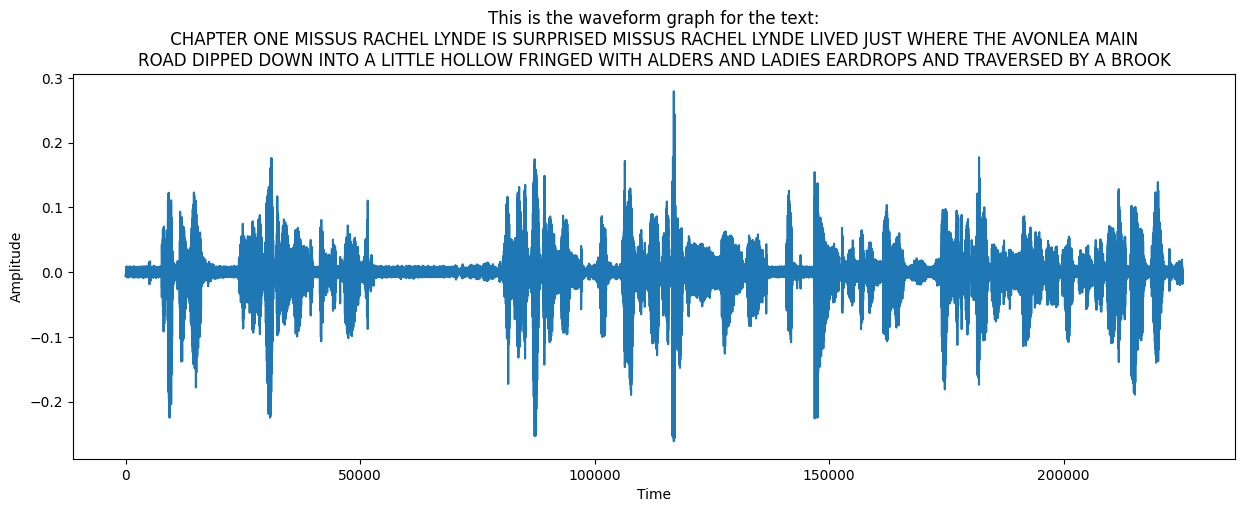

In [18]:
import matplotlib.pyplot as plt
waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
plt.figure(figsize =(15, 5))
plt.plot(waveform.t().numpy())
ln = len(utterance)
plt.title(f"This is the waveform graph for the text:\n {utterance[:ln//2-1]}\n{utterance[ln//2-1:]}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [19]:
%pip install Levenshtein
import Levenshtein

import numpy as np
def levenshtein_distance(ref, hyp):
    distance = Levenshtein.distance(ref, hyp)
    return distance

def normalize_text(text, ignore_case = False, remove_space = False):
    if ignore_case:
        text = text.lower()
    if remove_space:
        text = ''.join(text.split())
    return text

def calculate_errors(reference, hypothesis, ignore_case=False, remove_space=False, delimiter=None):
    reference = normalize_text(reference, ignore_case, remove_space)
    hypothesis = normalize_text(hypothesis, ignore_case, remove_space)

    if delimiter:
        reference = reference.split(delimiter)
        hypothesis = hypothesis.split(delimiter)

    edit_distance = levenshtein_distance(reference, hypothesis)
    ref_len = len(reference)

    return float(edit_distance), ref_len

def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, False, delimiter)
    return edit_distance / ref_len

def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    edit_distance, ref_len = calculate_errors(reference, hypothesis, ignore_case, remove_space)
    return edit_distance / ref_len
            


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 44.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [20]:
wer('Ronaldo GOAT', 'Ron GOAT siu')

1.0

# DATA + STArT PADDING

In [21]:
import string

class TextPreProcess:
    """Maps characters to integers and vice versa."""

    def __init__(self):
        self.vocab = ["''", "<SPACE>"] + list(string.ascii_lowercase)
        self.char_map = {ch: i for i, ch in enumerate(self.vocab)}
        self.index_map = {i: ch for ch, i in self.char_map.items()}
        self.index_map[self.char_map["<SPACE>"]] = " "

    def text_to_int(self, text: str):
        """Convert text -> integer sequence."""
        return [self.char_map.get(ch, self.char_map["<SPACE>"]) for ch in text.lower()]

    def int_to_text(self, labels: list[int]):
        """Convert integer sequence -> text."""
        return "".join(self.index_map[i] for i in labels if i in self.index_map)

    def int_to_text_remove_pad(self, labels: list[int]):
        """Remove trailing pad zeros, then convert."""
        while labels and labels[-1] == 0:
            labels.pop()
        return self.int_to_text(labels)

text_transform = TextPreProcess()
txt = "Ronaldo is the   GoaT"
ints = text_transform.text_to_int(txt)

print("Original:", txt)
print("To Int:", ints)
print("Recovered:", text_transform.int_to_text(ints))

test_int = [19, 16, 15, 2, 13, 5, 16, 1, 10, 20, 1, 21, 9, 6, 1, 1, 1, 8, 16, 2, 21]
print('star: ' + text_transform.int_to_text_remove_pad(test_int) + "|end")


Original: Ronaldo is the   GoaT
To Int: [19, 16, 15, 2, 13, 5, 16, 1, 10, 20, 1, 21, 9, 6, 1, 1, 1, 8, 16, 2, 21]
Recovered: ronaldo is the   goat
star: ronaldo is the   goat|end


In [22]:
import torch
import torch.nn as nn

text_transform = TextPreProcess()

texts = ["Ronaldo GOAT", "trying ts"]
labels = [torch.Tensor(text_transform.text_to_int(text)) for text in texts]
print(f"Labels without the 0 padding\n : {labels}")
labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
print(labels)

Labels without the 0 padding
 : [tensor([19., 16., 15.,  2., 13.,  5., 16.,  1.,  8., 16.,  2., 21.]), tensor([21., 19., 26., 10., 15.,  8.,  1., 21., 20.])]
tensor([[19., 16., 15.,  2., 13.,  5., 16.,  1.,  8., 16.,  2., 21.],
        [21., 19., 26., 10., 15.,  8.,  1., 21., 20.,  0.,  0.,  0.]])


# MEL SPECTROGRAM

In [23]:
# input for this will be a waveform, T\
# after Mel -> (n_mels, T) = 128, T
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = train_dataset[0]
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
spec.shape

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([1127, 128])

In [24]:
spectrograms = []
for waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id in [train_dataset[0], train_dataset[1]]:
    spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1) # (T, 128)
    print(len(spec))
    spectrograms.append(spec)
    print([type(x) for x in train_audio_transforms(waveform)])
spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
# first rnn.pad_sequence, T->T_max and batch in front = (batch, Tmax, 128)
# then unsqueeze(1) -> (batch, 1, T, 128)
# then transpose -> (batch, 1, 128, T)
# this is finally = BATCH * CHANNEL * FEATURE (MEL) * TIME = B*C*F*T (BATCH HERE was 2 as [train_dataset[0], train_dataset[1]])
spectrograms.size()

1127
[<class 'torch.Tensor'>]
1276
[<class 'torch.Tensor'>]


torch.Size([2, 1, 128, 1276])

In [25]:
pipeline_params = {
    'batch_size': 10,
    'epochs': 1,
    'learning_rate': 5e-4,
    'n_cnn_layers': 3, 
    'n_rnn_layers':5,
    'rnn_dim': 512,
    'n_class': 29,
    'n_feats':  128,
    'stride': 2,
    'dropout': 0.1
}
kwargs = {'num_workers':1, 'pin_memory': True}

# DATA PROCESSING

In [26]:
import torch
import torch.nn as nn

def data_processing(data, data_type = 'train'):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    
    audio_transforms = train_audio_transforms if data_type == 'train' else valid_audio_transforms
    
    for (waveform, _, utterance, _, _, _) in data:
        spec = audio_transforms(waveform).squeeze(0).transpose(0, 1) # (T, 128)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0] // 2)
        label_lengths.append(len(label))
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first = True).unsqueeze(1).transpose(2,3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first = True)
    return spectrograms, labels, input_lengths, label_lengths

In [27]:
import torch.utils.data as data
train_loader = data.DataLoader(dataset = train_dataset,
                              batch_size = pipeline_params['batch_size'],
                              shuffle = True,
                              collate_fn = lambda x: data_processing(x, 'train'),
                              **kwargs)
test_loader = data.DataLoader(dataset = test_dataset,
                             batch_size = pipeline_params['batch_size'],
                             shuffle = True,
                             collate_fn=lambda x: data_processing(x, 'valid'),
                             **kwargs)

In [28]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Picked Device', device)

Picked Device cuda


# MODEL

In [29]:
class CNNLayerNorm(nn.Module):
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layernorm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # BATCH * CHANNEL * FEATURE * TIME
        x = x.transpose(2, 3).contiguous()
        x = self.layernorm(x)
        return x.transpose(2, 3).contiguous()

In [30]:
class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()
        self.cnn1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel,
            stride=stride,
            padding=kernel//2,
        )
        self.cnn2 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel,
            stride=stride,
            padding=kernel//2,
        )
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x

In [31]:
class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()
        self.BiGRU = nn.GRU(
            input_size=rnn_dim,
            hidden_size=hidden_size,
            batch_first=batch_first,
            bidirectional=True
        )
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

# SPEECH RECOGNITION

In [32]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats // 2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)
        # in_channels, out_channels, kernel, stride, dropout, n_feats
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])

        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        # preprocessing done now lets train
        B,C,F,T = x.size()
        x = x.view(B,C*F,T) # B*F*T
        x = x.transpose(1, 2)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

model = SpeechRecognitionModel(
    pipeline_params['n_cnn_layers'],
    pipeline_params['n_rnn_layers'],
    pipeline_params['rnn_dim'],
    pipeline_params['n_class'],
    pipeline_params['n_feats'],
    pipeline_params['stride'],
    pipeline_params['dropout']
).to(device)

# TRAINING

In [33]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

optimizer = optim.AdamW(model.parameters(), pipeline_params["learning_rate"])

criterion = nn.CTCLoss(blank=28).to(device)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=pipeline_params["learning_rate"],
                                        steps_per_epoch=int(len(train_loader)),
                                        epochs=pipeline_params["epochs"],
                                        anneal_strategy="linear")

data_len = len(train_loader.dataset)
logging_idx = 0
logging_freq = 100
for epoch in range(pipeline_params["epochs"]):
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{pipeline_params['epochs']}", unit="batches")
    for batch_idx, _data in progress_bar:
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        if logging_idx % logging_freq == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, 
                batch_idx * len(spectrograms), 
                data_len, 100. * batch_idx / len(train_loader), 
                loss.item()
            ))
        logging_idx += 1
        progress_bar.set_postfix({'loss': loss.item()})


Epoch 1/1:   0%|          | 1/2854 [00:03<2:43:50,  3.45s/batches, loss=6.93]

Train Epoch: 0 [0/28539 (0%)]	Loss: 6.930407


Epoch 1/1:   4%|▎         | 101/2854 [00:46<20:29,  2.24batches/s, loss=2.91]

Train Epoch: 0 [1000/28539 (4%)]	Loss: 2.913905


Epoch 1/1:   7%|▋         | 201/2854 [01:31<21:00,  2.10batches/s, loss=2.85]

Train Epoch: 0 [2000/28539 (7%)]	Loss: 2.851005


Epoch 1/1:  11%|█         | 301/2854 [02:21<21:34,  1.97batches/s, loss=2.98]

Train Epoch: 0 [3000/28539 (11%)]	Loss: 2.978778


Epoch 1/1:  14%|█▍        | 401/2854 [03:11<19:59,  2.04batches/s, loss=2.87]

Train Epoch: 0 [4000/28539 (14%)]	Loss: 2.867294


Epoch 1/1:  18%|█▊        | 501/2854 [04:00<19:16,  2.03batches/s, loss=2.85]

Train Epoch: 0 [5000/28539 (18%)]	Loss: 2.845227


Epoch 1/1:  21%|██        | 601/2854 [04:49<18:53,  1.99batches/s, loss=2.85]

Train Epoch: 0 [6000/28539 (21%)]	Loss: 2.849022


Epoch 1/1:  25%|██▍       | 701/2854 [05:39<17:35,  2.04batches/s, loss=2.88]

Train Epoch: 0 [7000/28539 (25%)]	Loss: 2.879133


Epoch 1/1:  28%|██▊       | 801/2854 [06:29<16:49,  2.03batches/s, loss=2.88]

Train Epoch: 0 [8000/28539 (28%)]	Loss: 2.880691


Epoch 1/1:  32%|███▏      | 901/2854 [07:18<16:06,  2.02batches/s, loss=2.85]

Train Epoch: 0 [9000/28539 (32%)]	Loss: 2.846716


Epoch 1/1:  35%|███▌      | 1001/2854 [08:08<15:26,  2.00batches/s, loss=2.8] 

Train Epoch: 0 [10000/28539 (35%)]	Loss: 2.796470


Epoch 1/1:  39%|███▊      | 1101/2854 [08:58<14:34,  2.00batches/s, loss=2.65]

Train Epoch: 0 [11000/28539 (39%)]	Loss: 2.654961


Epoch 1/1:  42%|████▏     | 1201/2854 [09:48<13:54,  1.98batches/s, loss=2.33]

Train Epoch: 0 [12000/28539 (42%)]	Loss: 2.331438


Epoch 1/1:  46%|████▌     | 1301/2854 [10:38<12:38,  2.05batches/s, loss=2.12]

Train Epoch: 0 [13000/28539 (46%)]	Loss: 2.116582


Epoch 1/1:  49%|████▉     | 1401/2854 [11:28<12:04,  2.01batches/s, loss=2]   

Train Epoch: 0 [14000/28539 (49%)]	Loss: 1.996877


Epoch 1/1:  53%|█████▎    | 1501/2854 [12:17<11:00,  2.05batches/s, loss=2.03]

Train Epoch: 0 [15000/28539 (53%)]	Loss: 2.028290


Epoch 1/1:  56%|█████▌    | 1601/2854 [13:07<09:58,  2.09batches/s, loss=1.93]

Train Epoch: 0 [16000/28539 (56%)]	Loss: 1.927464


Epoch 1/1:  60%|█████▉    | 1701/2854 [13:57<09:47,  1.96batches/s, loss=1.79]

Train Epoch: 0 [17000/28539 (60%)]	Loss: 1.788497


Epoch 1/1:  63%|██████▎   | 1801/2854 [14:46<08:42,  2.01batches/s, loss=1.83]

Train Epoch: 0 [18000/28539 (63%)]	Loss: 1.831974


Epoch 1/1:  67%|██████▋   | 1901/2854 [15:37<07:55,  2.01batches/s, loss=1.66]

Train Epoch: 0 [19000/28539 (67%)]	Loss: 1.662620


Epoch 1/1:  70%|███████   | 2001/2854 [16:27<07:03,  2.01batches/s, loss=1.71]

Train Epoch: 0 [20000/28539 (70%)]	Loss: 1.708231


Epoch 1/1:  74%|███████▎  | 2101/2854 [17:16<06:19,  1.98batches/s, loss=1.57]

Train Epoch: 0 [21000/28539 (74%)]	Loss: 1.574771


Epoch 1/1:  77%|███████▋  | 2201/2854 [18:06<05:24,  2.01batches/s, loss=1.57]

Train Epoch: 0 [22000/28539 (77%)]	Loss: 1.569038


Epoch 1/1:  81%|████████  | 2301/2854 [18:56<04:38,  1.99batches/s, loss=1.56]

Train Epoch: 0 [23000/28539 (81%)]	Loss: 1.564191


Epoch 1/1:  84%|████████▍ | 2401/2854 [19:46<03:54,  1.93batches/s, loss=1.49]

Train Epoch: 0 [24000/28539 (84%)]	Loss: 1.492337


Epoch 1/1:  88%|████████▊ | 2501/2854 [20:36<02:53,  2.04batches/s, loss=1.44]

Train Epoch: 0 [25000/28539 (88%)]	Loss: 1.443973


Epoch 1/1:  91%|█████████ | 2601/2854 [21:26<02:07,  1.98batches/s, loss=1.46]

Train Epoch: 0 [26000/28539 (91%)]	Loss: 1.456873


Epoch 1/1:  95%|█████████▍| 2701/2854 [22:15<01:17,  1.97batches/s, loss=1.57]

Train Epoch: 0 [27000/28539 (95%)]	Loss: 1.571348


Epoch 1/1:  98%|█████████▊| 2801/2854 [23:05<00:26,  2.02batches/s, loss=1.39]

Train Epoch: 0 [28000/28539 (98%)]	Loss: 1.391827


Epoch 1/1: 100%|██████████| 2854/2854 [23:31<00:00,  2.02batches/s, loss=1.53]


In [48]:
# Save the model checkpoint
model_path = '/kaggle/working/speech_recognition_model.pth'
torch.save(model.state_dict(), model_path)

# STRING FIND

In [59]:
import torch
import torch.nn.functional as F
torch.manual_seed(1337)

text_transform = TextPreProcess()
def decode(outputs, blank=128):
    _, max_indices = torch.max(outputs, dim=2)
    output = []
    for idx, indexes in enumerate(max_indices.transpose(0, 1)):
        prev = -1
        res = []
        for index in indexes:
            if index not in [prev, blank]:
                res.append(index.item())
            prev = index
        output.append(res)
    return output

In [67]:
import torch
import torch.nn.functional as F
def validate(model, validation_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        all_predicted_texts = []
        all_true_texts = []
        for batch_idx, _data in tqdm(enumerate(validation_loader)):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            
            output = model(spectrograms)
            output =F.log_softmax(output, dim = 2)
            output = output.transpose(0, 1) # Needed for CTCLoss
            loss = criterion(output, labels, input_lengths, label_lengths)
            total_loss += loss.item()
            decoded_outputs = decode(output)
            predicted_texts = [text_transform.int_to_text(seq) for seq in decoded_outputs]
            true_texts  = [text_transform.int_to_text(label.tolist()) for label in labels]
            
            all_predicted_texts.extend(predicted_texts)
            all_true_texts.extend(true_texts)
            
        avg_loss = total_loss / len(validation_loader)
        avg_wer = np.mean([wer(ref, hyp) for ref, hyp in zip(all_true_texts,all_predicted_texts)])
        avg_cer = np.mean([cer(ref, hyp) for ref, hyp in zip(all_true_texts, all_predicted_texts)])
        
        print(f"Validation Loss: {avg_loss}")
        print(f"Average WER: {avg_wer:.4f}")
        print(f"Average CER: {avg_cer:.4f}")

In [68]:
validate(model, test_loader, criterion, device)

262it [01:37,  2.70it/s]

Validation Loss: 1.2670758862531821
Average WER: 0.8805
Average CER: 0.7831


In [64]:
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loaded_model = torch.load(model_path, map_location=device)
    return loaded_model

def speech_to_text(audio_path, model, device, text_transform, valid_audio_transform):
    waveform, _ = torchaudio.load(audio_path)
    waveform = valid_audio_transforms(waveform)
    waveform = waveform.unsqueeze(0).to(device)
    output = model(waveform)
    output = F.log_softmax(output, dim=2)
    output = output.transpose(0, 1)
    decoded_output = decode(output)
    predicted_text = text_transform.int_to_text(decoded_output[0])
    return predicted_text

In [65]:
import torch
torch.save(model.state_dict(), '/kaggle/working/speech_recognition_model.pt')

In [66]:
model = SpeechRecognitionModel(
    pipeline_params['n_cnn_layers'],
    pipeline_params['n_rnn_layers'], 
    pipeline_params['rnn_dim'], 
    pipeline_params['n_class'], 
    pipeline_params['n_feats'], 
    pipeline_params['stride'], 
    pipeline_params['dropout']
).to(device)

model.load_state_dict(torch.load('/kaggle/working/speech_recognition_model.pt'))
text_transform = TextPreProcess()
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

audio_path = '/kaggle/input/librispeech/LibriSpeech/dev-clean/174/50561/174-50561-0002.wav'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predicted_text = speech_to_text(audio_path, model, device, text_transform, valid_audio_transforms)
print(f"Predicted Text: {predicted_text}")

Predicted Text: bu thisis apolisy bu thisus apolisyn but thisus apolisy bu thisis appalecy u thisis apolesy bu thiis apolicy wut thisis apalasy bu thisus apolisy but tis is apolsy
